## Creative Content Assisted by Generative AI using Titan Image Generator: Inpainting Eraser
---
In this notebook, we will demonstrate how to create a Inpainting eraser that can remove any object from an image using Titan Image Generator in Bedrock. This tool can come in handy when you need to remove photobombs, get rid of unwanted objects, or even clean up backgrounds. 



### Setup

Add the import statements 

In [3]:
import os
import boto3
import json
import base64
from io import BytesIO
from random import randint
from PIL import Image

import io



### Helper function to prepare the request payload for submission to Bedrock

In [4]:

#get the stringified request body for the InvokeModel API call
def get_titan_image_inpainting_request_body(image_bytes=None, mask_prompt=None, negative_prompt=None):
    
    body = { #create the JSON payload to pass to the InvokeModel API
        "taskType": "INPAINTING",
        "inPaintingParams": {
            "image": image_bytes,
            "maskPrompt": mask_prompt,
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,  # Number of variations to generate
            "quality": "premium",  # Allowed values are "standard" and "premium"
            "height": 512,
            "width": 512,
            "cfgScale": 8.0,
            "seed": randint(0, 100000),  # Use a random seed
        },
    }
    
    return json.dumps(body)



### Helper functions to call Bedrock and extract image from the response


In [5]:
#get a BytesIO object from the Titan Image Generator response
def get_titan_response_image(response):
    
    response = json.loads(response.get('body').read())
    
    images = response.get('images')
    
    image_data = base64.b64decode(images[0])

    return BytesIO(image_data)


#generate an image using Amazon Titan Image Generator
def get_image_from_model(image_bytes, mask_prompt=None):
    session = boto3.Session(
        profile_name=os.environ.get("BWB_PROFILE_NAME")
    ) #sets the profile name to use for AWS credentials
    
    bedrock = session.client(
        service_name='bedrock-runtime', #creates a Bedrock client
        region_name=os.environ.get("BWB_REGION_NAME"),
        endpoint_url=os.environ.get("BWB_ENDPOINT_URL")
    ) 
    
    body = get_titan_image_inpainting_request_body(image_bytes, mask_prompt=mask_prompt)

   # print(body)

    response = bedrock.invoke_model(body=body, modelId="amazon.titan-image-generator-v1", contentType="application/json", accept="application/json")
    
    output = get_titan_response_image(response)
        
    return output



### Pass the image to the helper functions with the textual prompt that describes what needs to be erased

Original Image


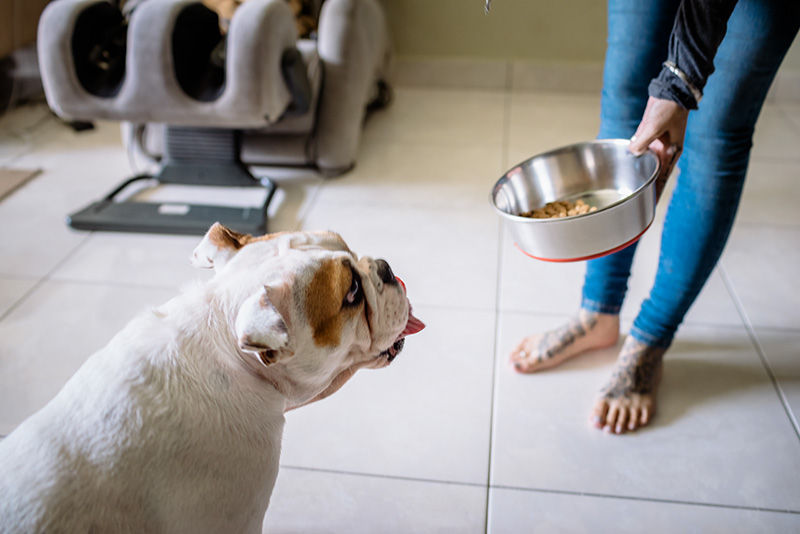

Masked Image


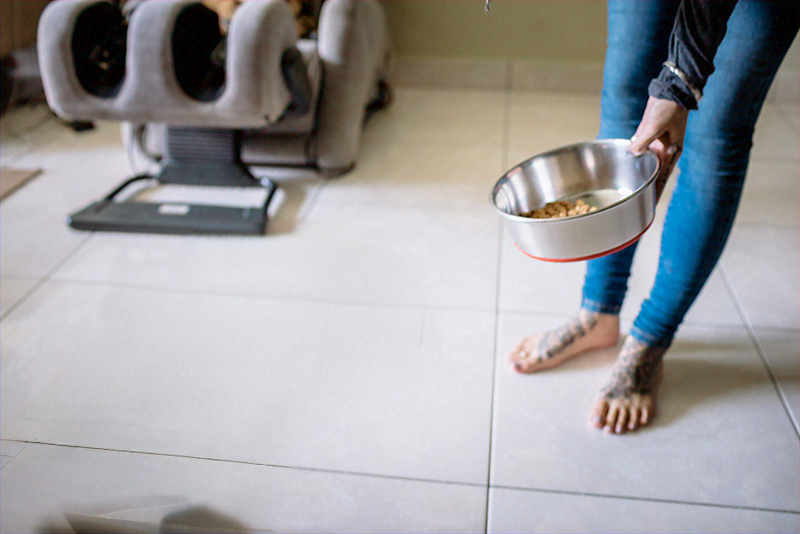

In [6]:

img_file='statics/dog.jpg'
original_image = Image.open(img_file)

print("Original Image")
display(original_image)


with open(img_file, "rb") as image_file:
            input_image = base64.b64encode(image_file.read()).decode('utf8')


image_bytes = get_image_from_model(input_image, "dog")


print("Masked Image")
image = Image.open(image_bytes)
display(image)
